# loading the classes 

In [1]:
from data_cleaning import *
from modeling import *
from preprocessing import *

# Splitting the data

In [2]:
def split_data(df,criteria='random'):
    X = df.drop(['fraud_bool'], axis=1)
    y = df['fraud_bool']
    if criteria=='paper':

        # Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
        X_train = X[X['month']<6]
        X_test = X[X['month']>=6]
        y_train = y[X['month']<6]
        y_test = y[X['month']>=6]


    elif criteria=='random':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    elif criteria=='stratify':

        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42) 

    X_train.drop('month', axis=1, inplace=True)
    X_test.drop('month', axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

# reading the data

In [3]:
df=data_cleaning('Base.csv').get_data()

In [4]:
# split the data
X_train, X_test, y_train, y_test=split_data(df,criteria= 'paper')

# getting the groups:

In [5]:
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

# start the preprocessing

In [6]:
data = preprocessing(X_train, y_train)


# Scaling numerical features:

In [7]:
scalers = {} 
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('standard',column)
    scalers[column] = scaler

In [8]:
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])

# encode the categorical features

In [9]:
encoders = {}
for column in X_train.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder

In [10]:
# apply the encoding on the testset
for column in X_test.select_dtypes(include=['object','category']).columns:
    ohe=encoders[column]
    encoded_col = pd.DataFrame(ohe.transform(X_test[column].values.reshape(-1, 1)).toarray(),index=X_test.index)
    encoded_col.columns = [column + '_' + str(val) for val in ohe.categories_[0]]
    X_test = pd.concat([X_test, encoded_col], axis=1)
    X_test.drop(columns=column, inplace=True,axis=1)  

In [11]:
# arrange the column names according to the concat data
X_test=X_test[data.concat_data().columns]

In [12]:
X_train,y_train=data.get_data()

# modeling : training and evaluation

In [13]:
experiment=modeling(X_train,X_test,y_train,y_test,train_groups,test_groups)

In [22]:

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for XGBoost
param_grid = {
'scale_pos_weight':[89.67005],
    'learning_rate':[0.1,0.01],
    'n_estimators':[100,200,150],
    'max_depth':[3,5,7]
}

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best hyperparameters: {'scale_pos_weight': 89.67005, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Best estimator: XGBClassifier(n_estimators=200, random_state=42, scale_pos_weight=89.67005)
Best score: 0.8983254200195433
AUC: 0.8938101227545131
TPR:  54.66% 
FPR:  4.99% 
Threshold:  0.78
Predictive Equality:  88.81%


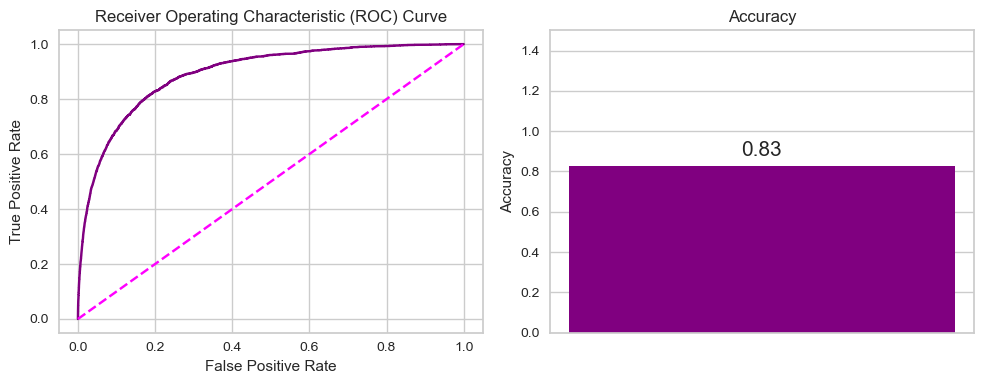

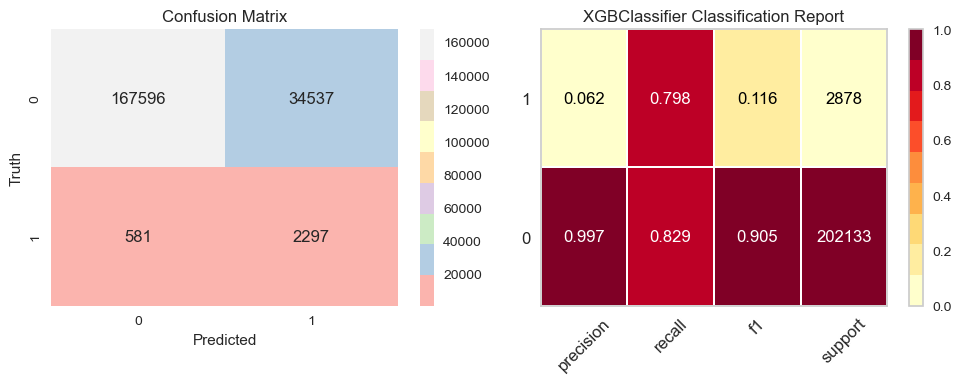

CPU times: total: 7min
Wall time: 33min 21s


In [23]:
%%time
experiment.train(xgb_model,param_grid=param_grid,search_type='random')

In [16]:
# Save the best model
saved_model_path = experiment.save_model('xgboost_model.pkl')
print("Model saved at:", saved_model_path)

Model saved at: xgboost_model.pkl
